In [20]:
from tqdm.notebook import tqdm 
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    accuracy_score,
    classification_report
)
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import numpy as np

from xgboost import XGBClassifier

from typing import List, Any, Tuple

import pickle

tqdm.pandas()

In [2]:
df_train = pd.read_csv('./../../../data/train.csv')
df_val = pd.read_csv('./../../../data/val.csv')
df_test = pd.read_csv('./../../../data/test.csv')

In [3]:
df_train = pd.concat([df_train, df_val])

In [4]:
df_train.head()

,corrected_text,length,ratio_err,labels
0,the story making mona lisa smile the author ta...,423,0.037825,3
1,the last ship try land venus was three decades...,342,0.038012,2
2,electrola college not just college process the...,715,0.027972,1
3,many countries are pushing towards less cars m...,608,0.004934,5
4,voters some times get confused about the lecte...,277,0.028881,2


In [5]:
df_train['text'] = df_train['corrected_text'].progress_apply(lambda x: ' '.join(preprocess_string(x)))

  0%|          | 0/13845 [00:00<?, ?it/s]

In [12]:
print(f"vocabulary size: {len(set(' '.join(df_train['text']).split()))}")

vocabulary size: 18559


In [13]:
df_train["labels"] = LabelEncoder().fit_transform(df_train["labels"])

In [14]:
df_train.labels.value_counts()

labels
2    5024
1    3778
3    3141
0    1001
4     776
5     125
Name: count, dtype: int64

In [15]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(df_train['text'])
y_train = df_train['labels']

X_train.shape

(13845, 18553)

In [19]:
def model_train(model: object,
                X: pd.DataFrame,
                y: pd.DataFrame,
                scoring: List[str])-> dict:
    """
    Return a dict of scores for the model 
    """
    scores = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1_macro', 'f1_weighted'], n_jobs=-1)

    return scores

In [18]:
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'XGBClassifier': XGBClassifier()
}

In [20]:
scoring = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro']

In [21]:
scores = {}

In [25]:
for model_name, model in tqdm(models.items()):
    scores[model_name] = model_train(model, X_train.toarray(), y_train, scoring)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
with open('scores.pkl', 'rb') as f:
    scores = pickle.load(f)

In [19]:
scores

{'RandomForestClassifier': {'fit_time': array([88.56587958, 89.70340919, 93.12885404, 84.34258032, 92.20869374]),
  'score_time': array([0.82652926, 0.69100118, 0.48736644, 0.81251931, 0.57416153]),
  'test_accuracy': array([0.50270856, 0.50343084, 0.50812568, 0.48717949, 0.50234742]),
  'test_f1_macro': array([0.27004102, 0.27596062, 0.26801914, 0.26301831, 0.27486865]),
  'test_f1_weighted': array([0.45804519, 0.46089891, 0.46188852, 0.44424348, 0.45971183])},
 'LogisticRegression': {'fit_time': array([116.00057602, 114.97800946, 124.66681314, 128.47227478,
         129.39941287]),
  'score_time': array([0.35700369, 0.38610625, 0.5539999 , 0.48209691, 0.43846297]),
  'test_accuracy': array([0.47778982, 0.48501264, 0.46984471, 0.4723727 , 0.48934633]),
  'test_f1_macro': array([0.30838597, 0.31835455, 0.2979262 , 0.31246852, 0.31895074]),
  'test_f1_weighted': array([0.45685952, 0.46527171, 0.44818106, 0.45292547, 0.46738191])},
 'GaussianNB': {'fit_time': array([26.25159836, 21.29504

In [17]:
from matplotlib import pyplot as plt

def plot_scores(scores: dict):
    for model_name, model_scores in scores.items():
        for score_name, score_values in model_scores.items():
            plt.plot(score_values, label=f"{model_name} {score_name}")
    plt.legend()
    plt.show()

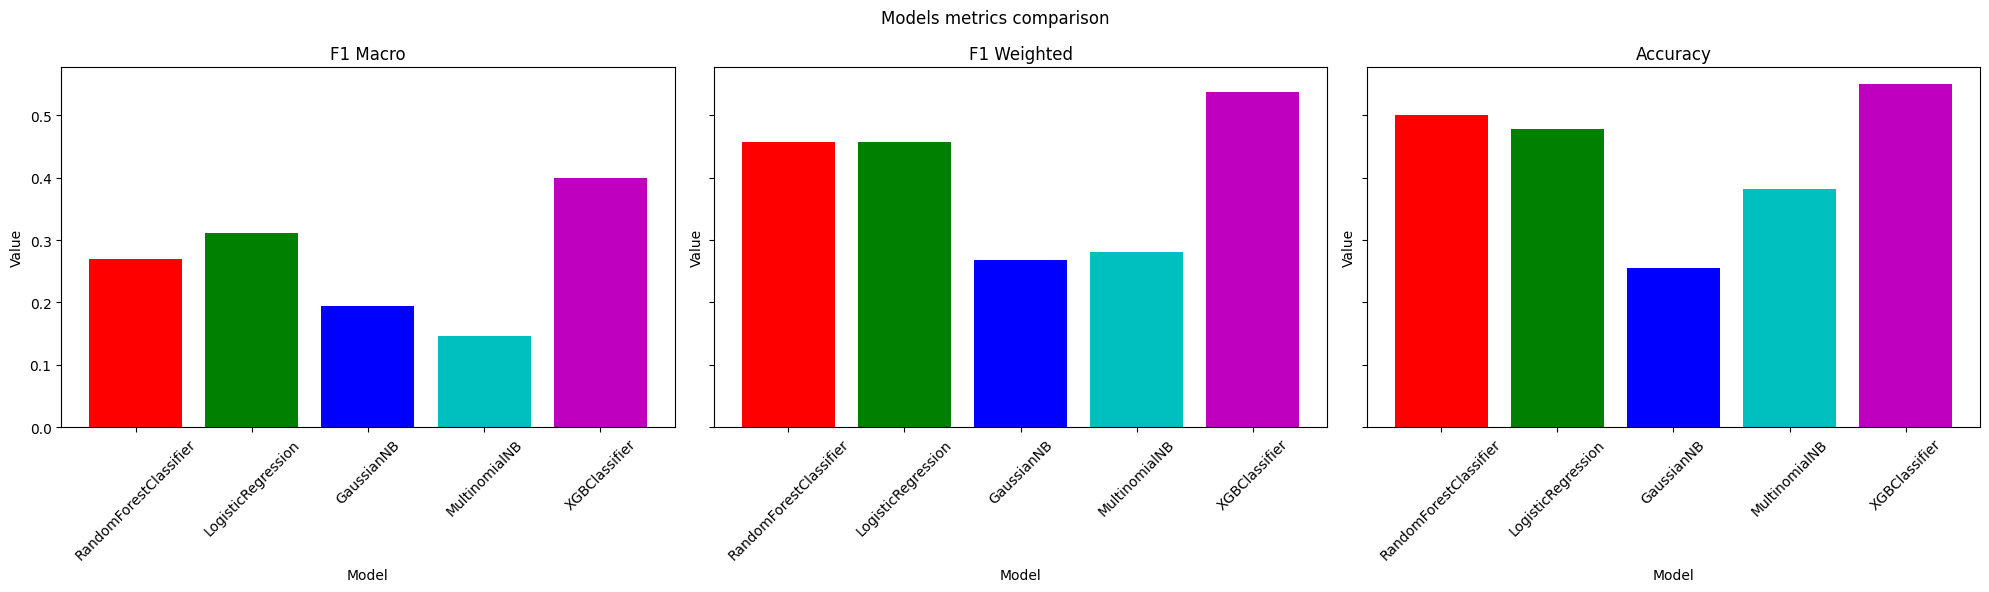

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

metrics = ['test_f1_macro', 'test_f1_weighted', 'test_accuracy']
titles = ['F1 Macro', 'F1 Weighted', 'Accuracy']
colors = ['r', 'g', 'b', 'c', 'm']

for ax, metric, title in zip(axes, metrics, titles):
    model_names = list(scores.keys())
    metric_means = [np.mean(scores[model][metric]) for model in model_names]
    
    ax.bar(model_names, metric_means, color=colors[:len(model_names)])
    ax.set_title(title)
    ax.set_xlabel('Model')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_ylabel('Value')

plt.suptitle('Models metrics comparison')
plt.tight_layout()
plt.show()

<img src="./../../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">

* We can see that models are not that performant. Even XGBoost has low results on train data.

* Assumption: Without even predicting results on the test set, we know that the models perfomances are going to be poor (by experience ^^).

* Knowing that, we should experiment more deeper models that could be suitable for our task, like `auto-encoder transformers`.
</div>